In [1]:
# Import library
# http://ufldl.stanford.edu/wiki/index.php/Independent_Component_Analysis
# http://ufldl.stanford.edu/tutorial/unsupervised/ICA/
# http://ufldl.stanford.edu/tutorial/unsupervised/ExerciseRICA/
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [2]:
# Read the Data Set and center it 
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import rescale, resize
dataset = fetch_olivetti_faces(shuffle=True)
train_data  = dataset.data.reshape(400,64,64)

print('---- Before Centering -------')
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

print('---- After Centering and reshaping -------')
train_data  = (train_data-train_data.mean(1)[:,np.newaxis]).reshape(400,64,64)
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

---- Before Centering -------
(400, 64, 64)
0.0 1.0
0.54704237 0.17251529
---- After Centering and reshaping -------
(400, 64, 64)
-0.70247936 0.66270673
-1.8373248e-09 0.13796239


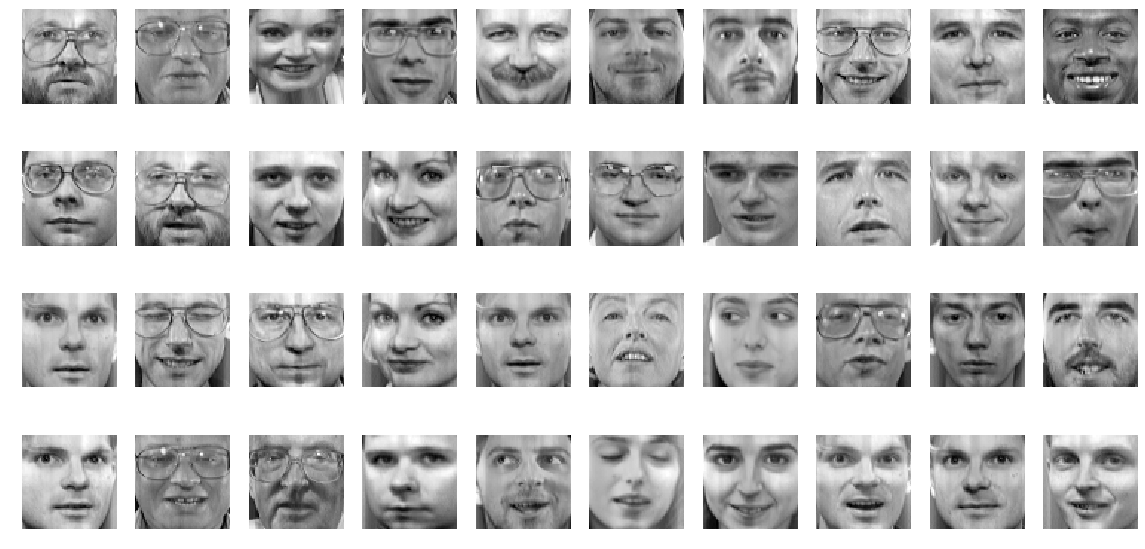

In [3]:
# show the image of the faces
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(train_data[i-1],cmap='gray')
plt.show()

In [4]:
# import all the layers
# ======= Activation Function  ==========
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)
# ======= Activation Function  ==========

class zca_whiten_layer():
    """ZCA Whiten operation layer.

    Parameters
    ----------
    self) : pass    def feedforward(self
        Description of parameter `self)`.
    input : type
        Description of parameter `input`.
    EPS : type
        Description of parameter `EPS`.

    Attributes
    ----------
    sigma : type
        Description of attribute `sigma`.
    eigenval : type
        Description of attribute `eigenval`.
    eigvector : type
        Description of attribute `eigvector`.
    U : type
        Description of attribute `U`.
    whiten : type
        Description of attribute `whiten`.
    self,grad : type
        Description of attribute `self,grad`.
    input

    """

    def __init__(self): pass

    def feedforward(self,input,EPS=0.0):
        self.input = input
        self.sigma = tf.matmul(tf.transpose(input),input) / input.shape[0]
        self.eigenval,self.eigvector = tf.linalg.eigh(self.sigma)
        self.U = tf.matmul(tf.matmul(self.eigvector,tf.diag(1./ tf.sqrt(self.eigenval+EPS))),tf.transpose(self.eigvector))
        self.whiten = tf.matmul(input,self.U)
        return self.whiten

    def backprop(self,grad,EPS=10e-5):
        d_U = tf.matmul(tf.transpose(self.input),grad)

        # ===== tf =====
        d_eig_value = self.eigvector.T.dot(d_U).dot(self.eigvector) * (-0.5) * np.diag(1. / (self.eigenval+EPS) ** 1.5)
        d_eig_vector = d_U.dot( (np.diag(1. / np.sqrt(self.eigenval+EPS)).dot(self.eigvector.T)).T  ) + (self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)))).dot(d_U)
        E = np.ones((grad.shape[1],1)).dot(np.expand_dims(self.eigenval.T,0)) - np.expand_dims(self.eigenval,1).dot(np.ones((1,grad.shape[1])))
        K_matrix = 1./(E + np.eye(grad.shape[1])) - np.eye(grad.shape[1])
        np.fill_diagonal(d_eig_value,0.0)
        d_sigma = self.eigvector.dot(
                    K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + d_eig_value
                    ).dot(self.eigvector.T)
        d_x = grad.dot(self.U.T) + (2./grad.shape[0]) * self.input.dot(d_sigma) * 2
        # ===== tf =====

        return d_x        

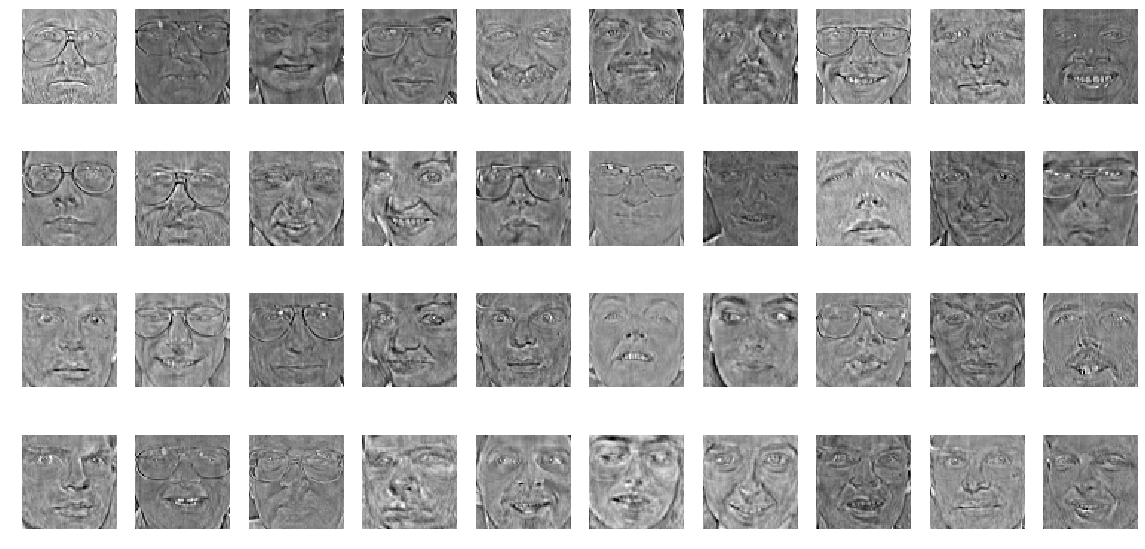

In [5]:
# Check ZCA whiten the data (per dimension)
# code from: https://gist.github.com/dmaniry/5170087
def fit(X):
    mean_data = np.mean(X, axis=0)
    X -= mean_data
    sigma = np.dot(X.T,X) / X.shape[1]
    from scipy import linalg as LA
    U, S, V = LA.svd(sigma)
    tmp = np.dot(U, np.diag(1/np.sqrt(S)))
    components_ = np.dot(tmp, U.T)
    return X.dot(components_)
zca_check_one = fit(train_data.reshape(400,-1)).reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_check_one[i-1],cmap='gray')
plt.show()

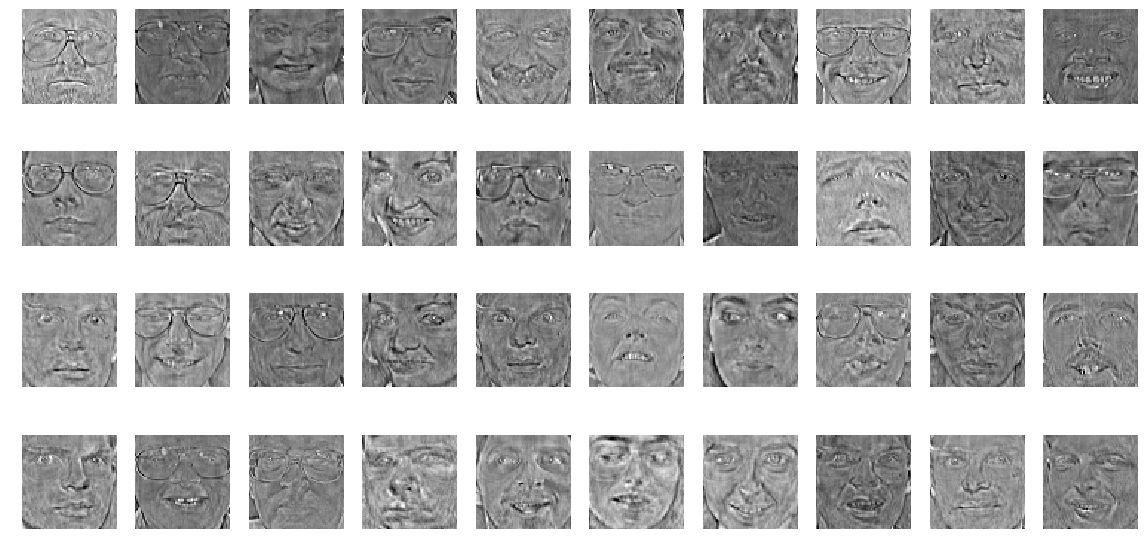

In [6]:
# Check ZCA whiten the data (per example) 
zca_check_two = fit(train_data.reshape(400,-1).T).T.reshape(400,64,64)
fig=plt.figure(figsize=(20, 10))
columns = 10; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_check_two[i-1],cmap='gray')
plt.show()

In [21]:
# Create the Orthonormal ICA Layer
class Orthonormal_ICA_Layer():
    
    def __init__(self,inc,outc):
        self.w = tf.Variable(tf.random_uniform(shape=[outc,inc],dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
            
    def getw(self): return self.w
        
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer
    
    def backprop(self,grad):
        grad_w  = self.w - learning_rate * tf.matmul(grad,tf.transpose(self.input))
        grad = tf.matmul(tf.pow(tf.matmul(grad_w,tf.transpose(grad_w)),-0.5),grad_w)
        grad_pass = tf.matmul(tf.transpose(self.w),grad)

        update_w = []
        update_w.append(tf.assign(self.w,grad  ))
        return grad_pass,update_w

In [25]:
# hyper parameter and class 
num_epoch = 10
learning_rate = 0.00008
print_size = 10

beta1,beta2,adam_e = 0.9,0.999,1e-8

# classes
num_of_basis_vector = 100
oica = Orthonormal_ICA_Layer(400,num_of_basis_vector)

# 
zca_check_two = zca_check_two.astype(np.float64)

In [26]:
# Create a Graph
x = tf.placeholder(shape=(400,64*64),dtype=tf.float64)

ica_layer = oica.feedforward(x)
cost = tf.sqrt(tf.pow(ica_layer,2) + 1e-10)
cost_mean = tf.reduce_mean(cost)
grad_pass,grad_update = oica.backprop(ica_layer/(ica_layer.shape[0].value * cost))

In [27]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epoch):
    sess_result = sess.run([cost_mean,cost,grad_update],feed_dict={x:zca_check_two.reshape((400,-1))})
    print('Current Iter: ',iter, ' cost mean: ',sess_result[0])

Current Iter:  0  cost mean:  1.44103936297033
Current Iter:  1  cost mean:  3.647447495193633
Current Iter:  2  cost mean:  3.6449857609027423
Current Iter:  3  cost mean:  3.6446120500565535
Current Iter:  4  cost mean:  3.644365073606473
Current Iter:  5  cost mean:  3.644149777578964
Current Iter:  6  cost mean:  3.643942400800607
Current Iter:  7  cost mean:  3.6437370033620318
Current Iter:  8  cost mean:  3.6435321003701473
Current Iter:  9  cost mean:  3.643327320624304


In [15]:
! start .

In [11]:
! git add .
! git commit -m "From Mac"
! git push

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


Everything up-to-date
